# Image Classification with KNN: Manhattan (L1) vs Euclidean (L2)
# 5-fold Cross-Validation on Cat/Dog/Panda Dataset

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict

In [6]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [7]:
DATASET_DIR = '/kaggle/input/animal/animal_dataset'

### Classes

In [8]:
classes = sorted(os.listdir(DATASET_DIR))
print("Classes found:", classes)

Classes found: ['cat', 'dog', 'panda']


In [9]:
IMG_SIZE = (32, 32)

In [10]:
X = []  # features
y = []  # labels
paths = []  # to keep image paths for later visualization

In [11]:
for label in classes:
    class_dir = os.path.join(DATASET_DIR, label)
    for fname in os.listdir(class_dir):
        fpath = os.path.join(class_dir, fname)
        # Basic filter to skip non-image files
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            continue
        
        try:
            img = Image.open(fpath).convert('L')          # convert to grayscale
            img = img.resize(IMG_SIZE)                    # resize to 32x32
            img_array = np.array(img, dtype=np.float32)   # (32, 32)
            img_array = img_array / 255.0                 # normalize to [0, 1]
            X.append(img_array.flatten())                 # flatten -> (1024,)
            y.append(label)
            paths.append(fpath)
        except Exception as e:
            print("Error loading:", fpath, "->", e)

X = np.array(X)  # shape: (N, 1024)
y = np.array(y)
paths = np.array(paths)

print("Data shape:", X.shape)
print("Label shape:", y.shape)

Data shape: (300, 1024)
Label shape: (300,)


In [12]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Encoded classes:", dict(zip(le.classes_, le.transform(le.classes_))))

Encoded classes: {'cat': 0, 'dog': 1, 'panda': 2}


In [13]:
k_values = [1, 3, 5, 7, 9, 11]
distance_metrics = ['manhattan', 'euclidean']  # L1 and L2

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [15]:

results = []  # to store (metric, k, mean_acc, std_acc)

for metric in distance_metrics:
    print(f"\n=== Distance Metric: {metric} ===")
    for k in k_values:
        knn = KNeighborsClassifier(
            n_neighbors=k,
            metric=metric
        )
        scores = cross_val_score(knn, X, y_encoded,
                                 cv=cv,
                                 scoring='accuracy',
                                 n_jobs=-1)
        mean_acc = scores.mean()
        std_acc = scores.std()
        results.append({
            'metric': metric,
            'k': k,
            'mean_acc': mean_acc,
            'std_acc': std_acc
        })
        print(f"K = {k:2d} | Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

results_df = pd.DataFrame(results)
display(results_df)


=== Distance Metric: manhattan ===
K =  1 | Accuracy: 0.3700 ± 0.0386
K =  3 | Accuracy: 0.3700 ± 0.0609
K =  5 | Accuracy: 0.3833 ± 0.0738
K =  7 | Accuracy: 0.3967 ± 0.0386
K =  9 | Accuracy: 0.4000 ± 0.0316
K = 11 | Accuracy: 0.4200 ± 0.0194

=== Distance Metric: euclidean ===
K =  1 | Accuracy: 0.3600 ± 0.0359
K =  3 | Accuracy: 0.3800 ± 0.0427
K =  5 | Accuracy: 0.3867 ± 0.0427
K =  7 | Accuracy: 0.3767 ± 0.0429
K =  9 | Accuracy: 0.4033 ± 0.0267
K = 11 | Accuracy: 0.4433 ± 0.0646


,metric,k,mean_acc,std_acc
0,manhattan,1,0.370000,0.038586
1,manhattan,3,0.370000,0.060919
2,manhattan,5,0.383333,0.073786
3,manhattan,7,0.396667,0.038586
4,manhattan,9,0.400000,0.031623
5,manhattan,11,0.420000,0.019437
6,euclidean,1,0.360000,0.035901
7,euclidean,3,0.380000,0.042687
8,euclidean,5,0.386667,0.042687
9,euclidean,7,0.376667,0.042947


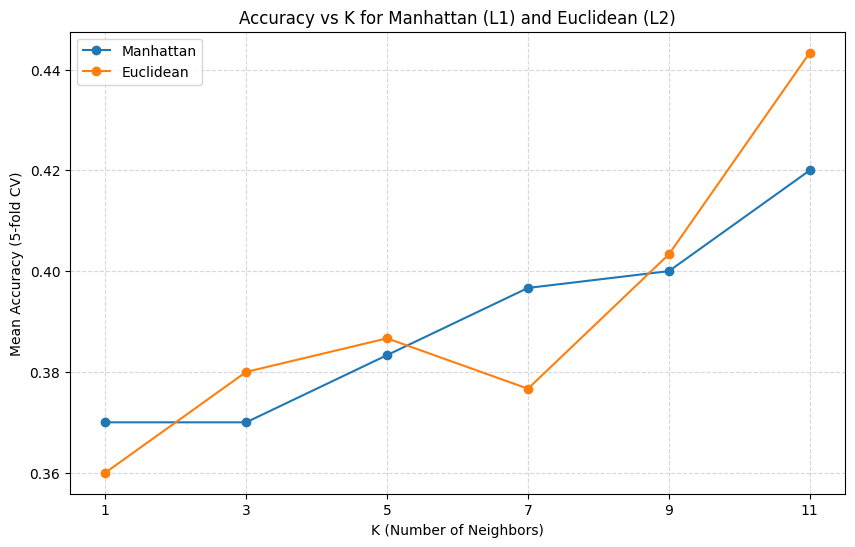

In [16]:
plt.figure(figsize=(10, 6))

for metric in distance_metrics:
    subset = results_df[results_df['metric'] == metric]
    plt.plot(subset['k'], subset['mean_acc'], marker='o', label=metric.capitalize())

plt.title('Accuracy vs K for Manhattan (L1) and Euclidean (L2)')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [17]:
best_row = results_df.iloc[results_df['mean_acc'].idxmax()]
best_metric = best_row['metric']
best_k = int(best_row['k'])
best_acc = best_row['mean_acc']

print("\nBest configuration:")
print(f"  Distance Metric : {best_metric}")
print(f"  K               : {best_k}")
print(f"  CV Accuracy     : {best_acc:.4f}")


Best configuration:
  Distance Metric : euclidean
  K               : 11
  CV Accuracy     : 0.4433


In [18]:
best_knn = KNeighborsClassifier(
    n_neighbors=best_k,
    metric=best_metric
)
best_knn.fit(X, y_encoded)

KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [20]:
y_pred_cv = cross_val_predict(best_knn, X, y_encoded, cv=cv, n_jobs=-1)
print("\nClassification Report (using best model with CV predictions):")
print(classification_report(y_encoded, y_pred_cv, target_names=le.classes_))


Classification Report (using best model with CV predictions):
              precision    recall  f1-score   support

         cat       0.46      0.43      0.44       100
         dog       0.39      0.73      0.51       100
       panda       0.85      0.17      0.28       100

    accuracy                           0.44       300
   macro avg       0.57      0.44      0.41       300
weighted avg       0.57      0.44      0.41       300



In [21]:
print("Confusion Matrix:")
print(confusion_matrix(y_encoded, y_pred_cv))

Confusion Matrix:
[[43 55  2]
 [26 73  1]
 [25 58 17]]


In [22]:
num_examples = 5
indices = np.random.choice(len(X), size=num_examples, replace=False)

In [23]:
X_examples = X[indices]
y_true_examples = y_encoded[indices]
paths_examples = paths[indices]

In [25]:
y_pred_examples = best_knn.predict(X_examples)

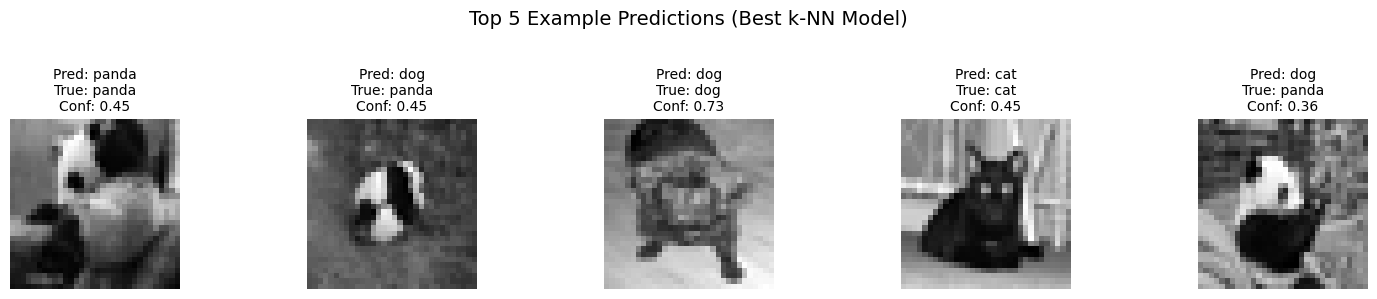

In [26]:
if hasattr(best_knn, "predict_proba"):
    y_proba_examples = best_knn.predict_proba(X_examples)
else:
    y_proba_examples = None

plt.figure(figsize=(15, 3))

for i, idx in enumerate(indices):
    plt.subplot(1, num_examples, i + 1)
    
    # Reshape back to 32x32 for display
    img = X[idx].reshape(IMG_SIZE)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    true_label = le.inverse_transform([y_true_examples[i]])[0]
    pred_label = le.inverse_transform([y_pred_examples[i]])[0]
    
    if y_proba_examples is not None:
        # predicted probability for that predicted class
        pred_prob = np.max(y_proba_examples[i])
        title = f"Pred: {pred_label}\nTrue: {true_label}\nConf: {pred_prob:.2f}"
    else:
        title = f"Pred: {pred_label}\nTrue: {true_label}"
    
    plt.title(title, fontsize=10)

plt.suptitle("Top 5 Example Predictions (Best k-NN Model)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [27]:
print("\nSummary:")
print(f"- Dataset: {len(X)} images of 3 classes: {', '.join(le.classes_)}")
print("- Images converted to grayscale 32x32 and flattened to 1024-d vectors.")
print(f"- Evaluated k-NN with Manhattan (L1) and Euclidean (L2) using 5-fold CV.")
print(f"- Best performance: metric = {best_metric}, K = {best_k}, "
      f"mean CV accuracy = {best_acc:.4f}")
print("- Top 5 predictions visualized above.")


Summary:
- Dataset: 300 images of 3 classes: cat, dog, panda
- Images converted to grayscale 32x32 and flattened to 1024-d vectors.
- Evaluated k-NN with Manhattan (L1) and Euclidean (L2) using 5-fold CV.
- Best performance: metric = euclidean, K = 11, mean CV accuracy = 0.4433
- Top 5 predictions visualized above.
